In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from trace_IO import *
from OptimumFilter import *

fs = 3906250
sigma = 0.7674
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
energy_values = list(range(5, 101, 5))
pass_rates_by_threshold = {th: [] for th in thresholds}
n_sets = 100

# Load templates and noise PSD
qp_template = np.load("templates/vac_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")

vac_of = OptimumFilter(qp_template, noise_psd, fs)


In [2]:
energy = 5
trace_path = f"/ceph/dwong/trigger_samples/lts/traces_energy_{energy}.zst"
loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)

In [3]:
example = loaded_traces[91][0]

In [4]:
example.shape

(300000,)

In [5]:
import numpy as np

trace = example  # assuming example is a 1D array of length 50000
window_size = 32768
num_windows = len(trace) - window_size + 1

def fit_window(i):
    segment = trace[i:i+window_size]
    return vac_of.fit(segment)

In [6]:


ampl_arr = []
chisq_arr = []
for i in range(num_windows):
    ampl, chisq = fit_window(i)
    ampl_arr.append(ampl)
    chisq_arr.append(chisq)

ampl_arr = np.array(ampl_arr)
chisq_arr = np.array(chisq_arr)


In [7]:
ampl_arr.shape

(267233,)

In [7]:
from joblib import Parallel, delayed
import numpy as np

trace = example  # assuming example is a 1D array of length 50000
window_size = 32768
num_windows = len(trace) - window_size + 1

def fit_window(i):
    segment = trace[i:i+window_size]
    return vac_of.fit(segment)

results = Parallel(n_jobs=-1)(delayed(fit_window)(i) for i in range(num_windows))
ampl_arr, chisq_arr = map(np.array, zip(*results))


In [9]:
len(ampl_arr)

267233

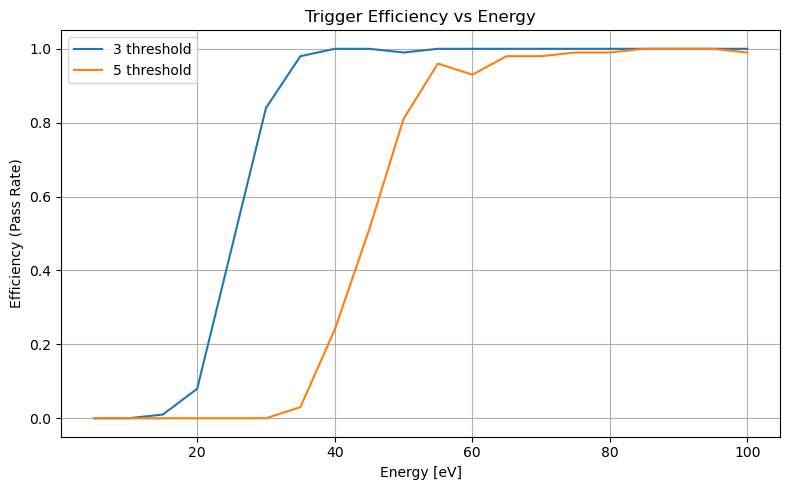

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

# Constants
fs = 3906250
sigma = 0.7674
thresholds = [3, 5]
energy_values = list(range(5, 101, 5))
pass_rates_by_threshold = {th: [] for th in thresholds}
n_sets = 100  # number of traces per energy


opt_filter = OptimumFilter(qp_template, noise_psd, sampling_frequency=fs)


def process_trace_set(trace_set):
    amps = [opt_filter.padding_OF(trace) for trace in trace_set]  # 9 traces
    return max(amps)

for energy in energy_values:
    trace_path = f"/ceph/dwong/trigger_samples/lts/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)  # shape: (100, 9, 300000)

    with ProcessPoolExecutor() as executor:
        final_amplitudes = list(executor.map(process_trace_set, loaded_traces))  # returns 100 amplitudes

    final_amplitudes = np.array(final_amplitudes)

    for th in thresholds:
        pass_rate = np.sum(final_amplitudes > th) / n_sets
        pass_rates_by_threshold[th].append(pass_rate)

plt.figure(figsize=(8, 5))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=f'{th} threshold')
plt.xlabel("Energy [eV]")
plt.ylabel("Efficiency (Pass Rate)")
plt.title("Trigger Efficiency vs Energy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]

print(thresholds)

[2.3022, 3.0696, 3.837]


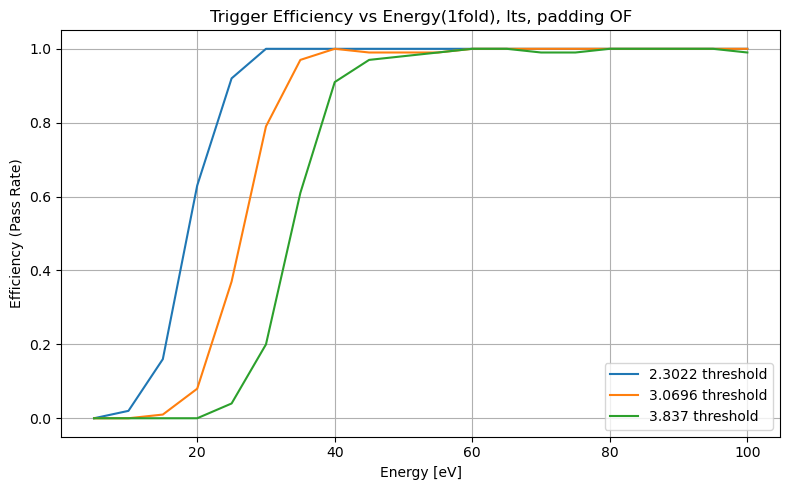

In [3]:
plt.figure(figsize=(8, 5))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=f'{th} threshold')
plt.xlabel("Energy [eV]")
plt.ylabel("Efficiency (Pass Rate)")
plt.title("Trigger Efficiency vs Energy(1fold), lts, padding OF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

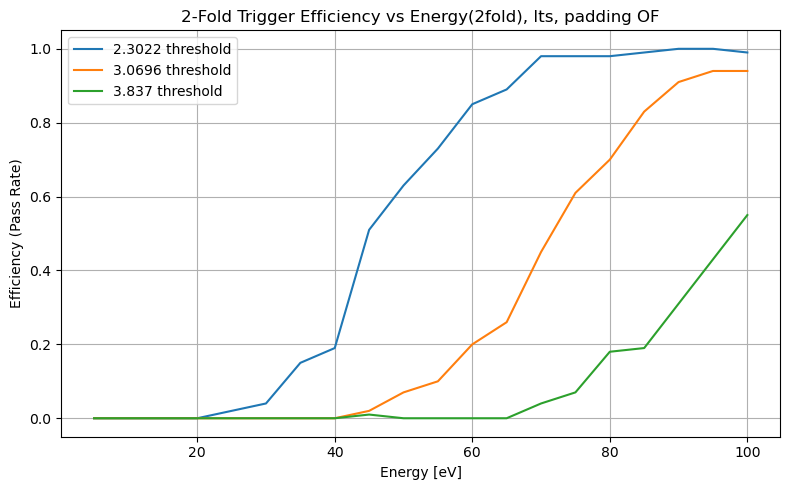

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

# Constants
fs = 3906250
sigma = 0.7674
thresholds = [round(n * sigma, 4) for n in [3, 4, 5]]
energy_values = list(range(5, 101, 5))
pass_rates_by_threshold = {th: [] for th in thresholds}
n_sets = 100  # number of traces per energy

# Function to load traces
# Make sure load_traces_from_zstd is defined somewhere else
# def load_traces_from_zstd(path, n_traces):
#     ...

# Create a single OptimumFilter instance
opt_filter = OptimumFilter(qp_template, noise_psd, sampling_frequency=fs)

# Function to be run in parallel
# Now returns the second largest amplitude from the 9 channels
def process_trace_set(trace_set):
    amps = [opt_filter.padding_OF(trace) for trace in trace_set]  # 9 traces
    amps_sorted = np.sort(amps)[-2]  # second largest amplitude
    return amps_sorted

# Loop over each energy
for energy in energy_values:
    trace_path = f"/ceph/dwong/trigger_samples/lts/traces_energy_{energy}.zst"
    loaded_traces = load_traces_from_zstd(trace_path, n_traces=n_sets)  # shape: (100, 9, 300000)

    # Run in parallel
    with ProcessPoolExecutor() as executor:
        final_amplitudes = list(executor.map(process_trace_set, loaded_traces))  # returns 100 amplitudes

    final_amplitudes = np.array(final_amplitudes)

    # Compare against thresholds
    for th in thresholds:
        pass_rate = np.sum(final_amplitudes > th) / n_sets
        pass_rates_by_threshold[th].append(pass_rate)

# Plot efficiency curves
plt.figure(figsize=(8, 5))
for th in thresholds:
    plt.plot(energy_values, pass_rates_by_threshold[th], label=f'{th} threshold')
plt.xlabel("Energy [eV]")
plt.ylabel("Efficiency (Pass Rate)")
plt.title("2-Fold Trigger Efficiency vs Energy(2fold), lts, padding OF")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Loading noise traces (0 eV)...


Processing noise sets: 100%|██████████| 100/100 [00:43<00:00,  2.28it/s]



Loading signal traces (0 eV)...


Processing 0 eV signal sets: 100%|██████████| 100/100 [00:36<00:00,  2.74it/s]



Loading signal traces (5 eV)...


Processing 5 eV signal sets: 100%|██████████| 100/100 [00:38<00:00,  2.59it/s]



Loading signal traces (10 eV)...


Processing 10 eV signal sets: 100%|██████████| 100/100 [00:41<00:00,  2.39it/s]



Loading signal traces (15 eV)...


Processing 15 eV signal sets: 100%|██████████| 100/100 [00:44<00:00,  2.24it/s]



Loading signal traces (20 eV)...


Processing 20 eV signal sets: 100%|██████████| 100/100 [00:41<00:00,  2.38it/s]



Loading signal traces (25 eV)...


Processing 25 eV signal sets: 100%|██████████| 100/100 [00:44<00:00,  2.26it/s]



Loading signal traces (30 eV)...


Processing 30 eV signal sets: 100%|██████████| 100/100 [00:40<00:00,  2.50it/s]


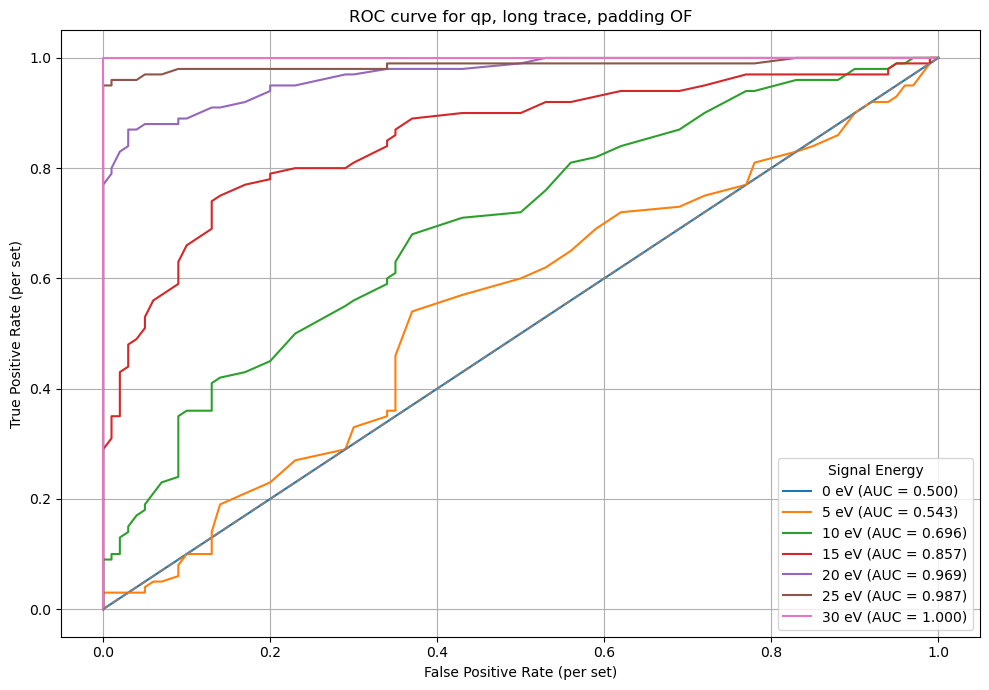

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from tqdm import tqdm

# Parameters
signal_energies = [0, 5, 10, 15, 20, 25, 30]  # eV
n_noise_sets = 100
n_signal_sets = 100
traces_per_set = 9

# --- Load noise (0 eV) once ---
print("Loading noise traces (0 eV)...")
noise_traces = load_traces_from_zstd("/ceph/dwong/trigger_samples/lts/traces_energy_0.zst", n_traces=n_noise_sets)
noise_max_amplitudes = []
for traces in tqdm(noise_traces, desc="Processing noise sets"):
    amps = [vac_of.padding_OF(trace) for trace in traces]
    noise_max_amplitudes.append(np.max(amps))
noise_max_amplitudes = np.array(noise_max_amplitudes)

# --- Prepare threshold sweep ---
thresholds = np.linspace(0, 6, 500)

plt.figure(figsize=(10, 7))

# --- Process each signal energy ---
for signal_energy in signal_energies:
    print(f"\nLoading signal traces ({signal_energy} eV)...")
    signal_traces = load_traces_from_zstd(f"/ceph/dwong/trigger_samples/lts/traces_energy_{signal_energy}.zst", n_traces=n_signal_sets)
    signal_max_amplitudes = []
    for traces in tqdm(signal_traces, desc=f"Processing {signal_energy} eV signal sets"):
        amps = [vac_of.padding_OF(trace) for trace in traces]
        signal_max_amplitudes.append(np.max(amps))
    signal_max_amplitudes = np.array(signal_max_amplitudes)

    # Compute ROC
    tpr = []
    fpr = []
    for th in thresholds:
        tpr.append(np.sum(signal_max_amplitudes > th) / n_signal_sets)
        fpr.append(np.sum(noise_max_amplitudes > th) / n_noise_sets)

    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{signal_energy} eV (AUC = {roc_auc:.3f})")

# Finalize plot
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate (per set)')
plt.ylabel('True Positive Rate (per set)')
plt.title('ROC curve for qp, long trace, padding OF')
plt.legend(title='Signal Energy')
plt.grid(True)
plt.tight_layout()
plt.show()
